<a href="https://colab.research.google.com/github/khanfs/pan-coronavirus-antivirals/blob/main/SARS_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**SARS-CoV Compounds & Bioactivity Data**
##**Data Collection and Preprocessing**


In [1]:
# Import packages, modules and libraries 
import math 
from pathlib import Path 
from zipfile import ZipFile 
from tempfile import TemporaryDirectory 
from tqdm.auto import tqdm 

import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 

In [2]:
# Install NBVAL
! pip install nbval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Install RDKit
! pip install rdkit-pypi -qqq

In [4]:
from rdkit import Chem
from rdkit.Chem import PandasTools

In [5]:
# Install ChEMBL library to access ChEMBL data and cheminformatics tools
! pip install chembl_webresource_client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# Import ChEMBL library settings to use library 
from chembl_webresource_client.settings import Settings

In [7]:
# Import new_client object: imports the new functions of the library
from chembl_webresource_client.new_client import new_client

In [8]:
# Create resource objects for API access
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [9]:
type(targets_api)

chembl_webresource_client.query_set.QuerySet

###**2. Get SARS-CoV-1 Target Data**

In [10]:
uniprot_id = "P0C6X7" # SARS-CoV-1 

In [11]:
# Get target information from ChEMBL but restrict it to specified values only
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'The type of the targets is "{type(targets)}"')

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


Download target data from ChEMBL

In [12]:
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,SARS coronavirus,Replicase polyprotein 1ab,CHEMBL5118,SINGLE PROTEIN
1,SARS coronavirus,Replicase polyprotein 1ab,CHEMBL5118,SINGLE PROTEIN


Select target (target ChEMBL ID)

In [13]:
target = targets.iloc[1] 
target

organism                     SARS coronavirus
pref_name           Replicase polyprotein 1ab
target_chembl_id                   CHEMBL5118
target_type                    SINGLE PROTEIN
Name: 1, dtype: object

Save selected ChEMBL ID

In [14]:
chembl_id = target.target_chembl_id
print(f"The target ChEMBL ID is {chembl_id}")
# NBVAL_CHECK_OUTPUT

The target ChEMBL ID is CHEMBL5118


###**3. Get Bioactivity Data**

Fetch the bioactivity data and filter according to:

* human proteins
* bioactivity type IC50,
* exact measurements (relation '='), and
* binding data (assay type 'B')

In [15]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 177, <class 'chembl_webresource_client.query_set.QuerySet'>


In [16]:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]

Length and type of first element: 13, <class 'dict'>


{'activity_id': 1988091,
 'assay_chembl_id': 'CHEMBL898907',
 'assay_description': 'Inhibition of SARS-CoV 3C-like protease by FRET based microplate assay',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL194398',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '870000.0',
 'target_chembl_id': 'CHEMBL5118',
 'target_organism': 'SARS coronavirus',
 'type': 'IC50',
 'units': 'uM',
 'value': '870.0'}

Download bioactivity data from ChEMBL

In [17]:
bioactivities_df = pd.DataFrame.from_records(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (178, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,1988091,CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,CHEMBL194398,=,nM,870000.0,CHEMBL5118,SARS coronavirus,IC50,uM,870.0
1,1988091,CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,CHEMBL194398,=,nM,870000.0,CHEMBL5118,SARS coronavirus,IC50,uM,870.0
2,1988092,CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,CHEMBL393608,=,nM,200000.0,CHEMBL5118,SARS coronavirus,IC50,uM,200.0
3,1988093,CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,CHEMBL238216,=,nM,300000.0,CHEMBL5118,SARS coronavirus,IC50,uM,300.0
4,1988094,CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,CHEMBL235873,=,nM,15000.0,CHEMBL5118,SARS coronavirus,IC50,uM,15.0


In [18]:
bioactivities_df.columns

Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'standard_units', 'standard_value',
       'target_chembl_id', 'target_organism', 'type', 'units', 'value'],
      dtype='object')

In [19]:
bioactivities_df["units"].unique()

array(['uM'], dtype=object)

In [20]:
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,1988091,CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,CHEMBL194398,=,nM,870000.0,CHEMBL5118,SARS coronavirus,IC50
1,1988091,CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,CHEMBL194398,=,nM,870000.0,CHEMBL5118,SARS coronavirus,IC50
2,1988092,CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,CHEMBL393608,=,nM,200000.0,CHEMBL5118,SARS coronavirus,IC50
3,1988093,CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,CHEMBL238216,=,nM,300000.0,CHEMBL5118,SARS coronavirus,IC50
4,1988094,CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,CHEMBL235873,=,nM,15000.0,CHEMBL5118,SARS coronavirus,IC50


**Preprocess and filter bioactivity data**:

1. Convert standard_value’s datatype from object to float
2. Delete entries with missing values
3. Keep only entries with standard_unit == nM
4. Delete duplicate molecules
5. Reset DataFrame index
6. Rename columns


**1. Convert datatype of “standard_value” from “object” to “float”**

The field standard_value holds standardized (here IC50) values. In order to make these values usable in calculations later on, convert values to floats.

In [21]:
bioactivities_df.dtypes

activity_id            int64
assay_chembl_id       object
assay_description     object
assay_type            object
molecule_chembl_id    object
relation              object
standard_units        object
standard_value        object
target_chembl_id      object
target_organism       object
type                  object
dtype: object

In [22]:
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
bioactivities_df.dtypes

activity_id             int64
assay_chembl_id        object
assay_description      object
assay_type             object
molecule_chembl_id     object
relation               object
standard_units         object
standard_value        float64
target_chembl_id       object
target_organism        object
type                   object
dtype: object

**2. Delete entries with missing values**

In [23]:
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (178, 11)


**3. Keep only entries with “standard_unit == nM”**

In [24]:
print(f"Units in downloaded data: {bioactivities_df['standard_units'].unique()}")
print(
    f"Number of non-nM entries:\
    {bioactivities_df[bioactivities_df['standard_units'] != 'nM'].shape[0]}"
)

Units in downloaded data: ['nM']
Number of non-nM entries:    0


In [25]:
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}")

Units after filtering: ['nM']


In [26]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (178, 11)


**4. Delete duplicate molecules**

In [27]:
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (152, 11)


**5. Reset “DataFrame” index**

In [28]:
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,1988091,CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,CHEMBL194398,=,nM,870000.0,CHEMBL5118,SARS coronavirus,IC50
1,1988092,CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,CHEMBL393608,=,nM,200000.0,CHEMBL5118,SARS coronavirus,IC50
2,1988093,CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,CHEMBL238216,=,nM,300000.0,CHEMBL5118,SARS coronavirus,IC50
3,1988094,CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,CHEMBL235873,=,nM,15000.0,CHEMBL5118,SARS coronavirus,IC50
4,1988095,CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,CHEMBL397154,=,nM,10000.0,CHEMBL5118,SARS coronavirus,IC50


In [29]:
bioactivities_df.columns

Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'standard_units', 'standard_value',
       'target_chembl_id', 'target_organism', 'type'],
      dtype='object')

**6. Rename columns**

In [30]:
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,1988091,CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,CHEMBL194398,=,nM,870000.0,CHEMBL5118,SARS coronavirus,IC50
1,1988092,CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,CHEMBL393608,=,nM,200000.0,CHEMBL5118,SARS coronavirus,IC50
2,1988093,CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,CHEMBL238216,=,nM,300000.0,CHEMBL5118,SARS coronavirus,IC50
3,1988094,CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,CHEMBL235873,=,nM,15000.0,CHEMBL5118,SARS coronavirus,IC50
4,1988095,CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,CHEMBL397154,=,nM,10000.0,CHEMBL5118,SARS coronavirus,IC50


In [31]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (152, 11)


###**4. Get compound data**

**1. Fetch compound data from ChEMBL**

Let’s have a look at the compounds from ChEMBL which we have defined bioactivity data for: We fetch compound ChEMBL IDs and structures for the compounds linked to our filtered bioactivity data.

In [32]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

**Download compound data from ChEMBL**

In [33]:
compounds = list(tqdm(compounds_provider))

  0%|          | 0/152 [00:00<?, ?it/s]

In [34]:
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (152, 2)


In [35]:
compounds_df.head()

,molecule_chembl_id,molecule_structures
0,CHEMBL28,{'canonical_smiles': 'O=c1cc(-c2ccc(O)cc2)oc2c...
1,CHEMBL8145,{'canonical_smiles': 'O=c1c(-c2ccc(O)cc2)coc2c...
2,CHEMBL50,{'canonical_smiles': 'O=c1c(O)c(-c2ccc(O)c(O)c...
3,CHEMBL12798,{'canonical_smiles': 'COC(=O)[C@]1(C)CCC[C@]2(...
4,CHEMBL151,{'canonical_smiles': 'O=c1cc(-c2ccc(O)c(O)c2)o...


**2. Preprocess and filter compound data**

1. Remove entries with missing entries
2. Delete duplicate molecules (by molecule_chembl_id)
3. Get molecules with canonical SMILES

**1. Remove entries with missing molecule structure entry**

In [36]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (152, 2)


**2. Delete duplicate molecules**

In [37]:
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (152, 2)


**3. Get molecules with canonical SMILES**

In [38]:
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [39]:
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (152, 2)


Remove all molecules without a canonical SMILES string.

In [40]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (152, 2)


###**5. Output bioactivity-compound data**

1. Merge bioactivity and compound data, and add pIC50 values
2. Draw molecules with highest pIC50
3. Freeze bioactivity data to ChEMBL 27
4. Write output file

**Summary of compound and bioactivity data**

In [41]:
print(f"Bioactivities filtered: {bioactivities_df.shape[0]}")
bioactivities_df.columns

Bioactivities filtered: 152


Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'units', 'IC50', 'target_chembl_id',
       'target_organism', 'type'],
      dtype='object')

In [42]:
print(f"Compounds filtered: {compounds_df.shape[0]}")
compounds_df.columns

Compounds filtered: 152


Index(['molecule_chembl_id', 'smiles'], dtype='object')

**1. Merge both datasets**

Merge values of interest from bioactivities_df and compounds_df in an output_df based on the compounds’ ChEMBL IDs (molecule_chembl_id), keeping the following columns:

* ChEMBL IDs: molecule_chembl_id
* SMILES: smiles
* units: units
* IC50: IC50

In [43]:
# Merge DataFrames
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f"Dataset with {output_df.shape[0]} entries.")

Dataset with 152 entries.


In [44]:
output_df.dtypes

molecule_chembl_id     object
IC50                  float64
units                  object
smiles                 object
dtype: object

In [45]:
output_df.head(10)

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL194398,870000.0,nM,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@@H...
1,CHEMBL393608,200000.0,nM,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...
2,CHEMBL238216,300000.0,nM,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...
3,CHEMBL235873,15000.0,nM,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...
4,CHEMBL397154,10000.0,nM,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...
5,CHEMBL238217,80000.0,nM,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...
6,CHEMBL196635,800000.0,nM,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...
7,CHEMBL492571,5400.0,nM,O=C(O)/C(O)=C/C(=O)c1cccc(NCc2ccccc2)c1
8,CHEMBL522710,11000.0,nM,O=C(O)/C(O)=C/C(=O)c1cccc(NCc2ccc(Cl)cc2)c1
9,CHEMBL492771,13600.0,nM,O=C(O)/C(O)=C/C(=O)c1cccc(OCc2ccc(Cl)cc2)c1


**Add pIC50 values**

IC50 values are difficult to read (values are distributed over multiple scales), **which is why we convert the IC50 values to pIC50**.

In [46]:
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

In [47]:
# Apply conversion to each row of the compounds DataFrame
output_df["pIC50"] = output_df.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)

In [48]:
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL194398,870000.0,nM,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@@H...,3.060481
1,CHEMBL393608,200000.0,nM,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,3.698970
2,CHEMBL238216,300000.0,nM,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,3.522879
3,CHEMBL235873,15000.0,nM,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,4.823909
4,CHEMBL397154,10000.0,nM,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,5.000000


**Plot the pIC50 value distribution**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f417523c750>]],
      dtype=object)

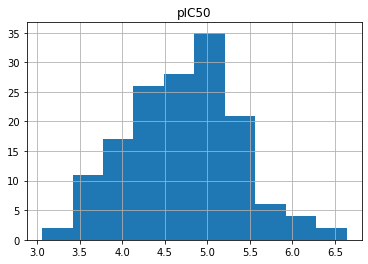

In [49]:
output_df.hist(column="pIC50")

Add a column for RDKit molecule objects to our DataFrame and look at the structures of the molecules with the highest pIC50 values.

In [50]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol="smiles")

In [51]:
# Sort molecules by pIC50
output_df.sort_values(by="pIC50", ascending=False, inplace=True)

# Reset index
output_df.reset_index(drop=True, inplace=True)

Show the 3 most active molecules, i.e. molecules with the highest pIC50 values.

,molecule_chembl_id,IC50,units,pIC50,ROMol
0,CHEMBL2441741,230.0,nM,6.638272,
1,CHEMBL221366,500.0,nM,6.301030,
2,CHEMBL2441745,610.0,nM,6.214670,

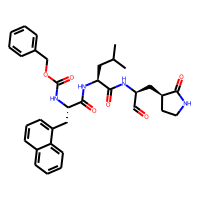
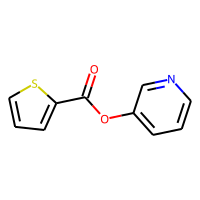
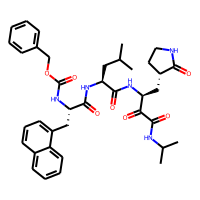

In [52]:
output_df.drop("smiles", axis=1).head(3)

In [53]:
# Save dataset without ROMol column
output_df = output_df.drop("ROMol", axis=1)
print(f"DataFrame shape: {output_df.shape}")

DataFrame shape: (152, 5)


In [56]:
# Save dataset in a CSV file
output_df.to_csv('SARS-CoV_Compounds.csv', index=False)
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL2441741,230.0,nM,CC(C)C[C@H](NC(=O)[C@H](Cc1cccc2ccccc12)NC(=O)...,6.638272
1,CHEMBL221366,500.0,nM,O=C(Oc1cccnc1)c1cccs1,6.301030
2,CHEMBL2441745,610.0,nM,CC(C)C[C@H](NC(=O)[C@H](Cc1cccc2ccccc12)NC(=O)...,6.214670
3,CHEMBL1876821,940.0,nM,CN(CC(=O)NC1CCCC1)S(=O)(=O)c1cccc(Cl)c1,6.026872
4,CHEMBL3099526,1040.0,nM,CC1CCN(S(=O)(=O)c2ccc3c(c2)C(=O)C(=O)N3C)CC1,5.982967


In [57]:
print(f"DataFrame shape: {output_df.shape}") # NBVAL_CHECK_OUTPUT

DataFrame shape: (152, 5)
